## Neural Network Design Choices Using Fashion-MNIST

**Portfolio Piece 1** — Extending Lab 2 (Neural Network Exploration)

---

## Motivation

In Lab 2, we built simple neural networks on XOR and MNIST to see gradient descent in action. The results were encouraging, but MNIST digit classification is essentially a *solved* problem — even a basic MLP hits 97%+, which leaves little room to see how design choices actually matter.

**Fashion-MNIST** changes this. Introduced by Zalando Research as a drop-in MNIST replacement, it uses the same 28×28 grayscale format but presents a much harder task: distinguishing t-shirts from pullovers, sneakers from ankle boots, and coats from shirts. These classes have real visual overlap, which means architecture, optimization, and regularization decisions have *measurable impact* on performance.

This notebook systematically investigates three questions:
1. **Architecture**: How do depth, width, activation functions, and skip connections affect what a network can learn?
2. **Optimization**: How do different optimizers, learning rate schedules, and regularization strategies change the training dynamics?
3. **Interpretability**: What is the network actually learning, and where does it fail?

Each experiment is designed to isolate a single variable so we can draw meaningful conclusions about *why* certain choices work better than others.

---
## 1. Setup & Data Exploration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sys, os

# Add src/ to path so we can import our utilities
sys.path.append(os.path.join(os.pardir, 'src'))
from utils import (
    train_model, plot_training_curves, plot_confusion_matrix,
    extract_features, plot_tsne, compare_experiments, count_parameters
)

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Fashion-MNIST class names
CLASS_NAMES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Standard normalization for Fashion-MNIST (mean=0.2860, std=0.3530)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# Load datasets
train_dataset = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_dataset  = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

# DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples:     {len(test_dataset):,}")
print(f"Image shape:      {train_dataset[0][0].shape}")
print(f"Classes:          {len(CLASS_NAMES)}")

100%|██████████| 26.4M/26.4M [00:57<00:00, 463kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 231kB/s]
100%|██████████| 4.42M/4.42M [00:03<00:00, 1.27MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.62MB/s]

Training samples: 60,000
Test samples:     10,000
Image shape:      torch.Size([1, 28, 28])
Classes:          10


### 1.1 Visualizing the Dataset

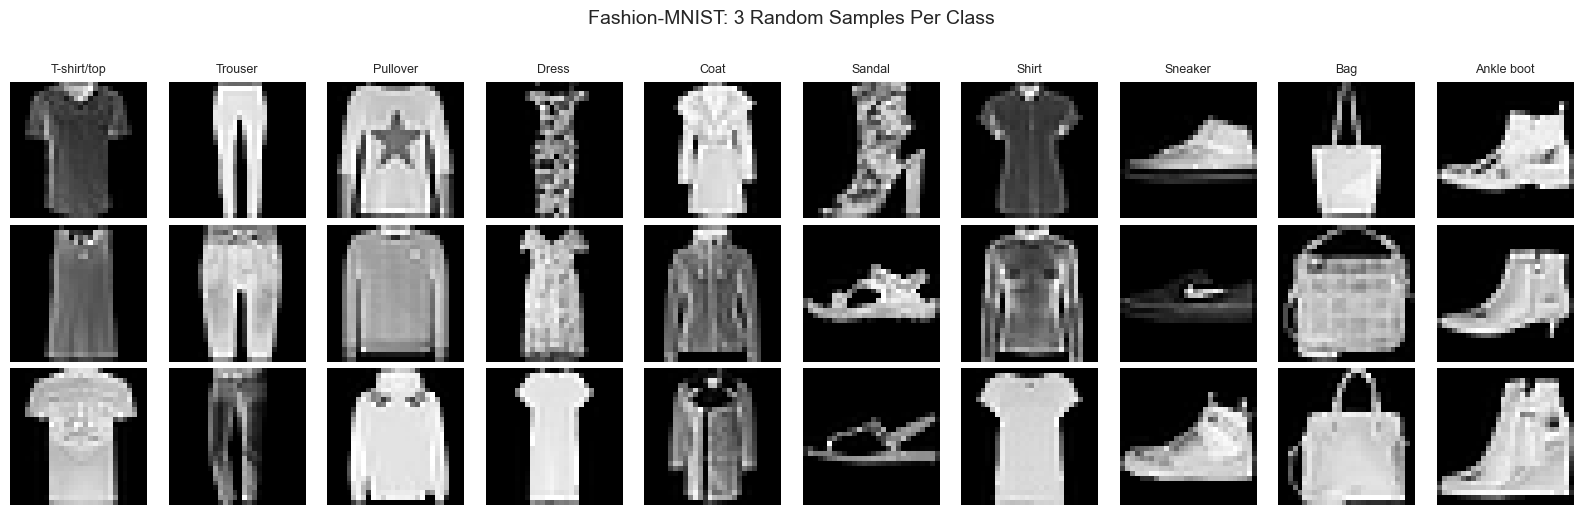

In [3]:
# Show 3 examples per class
fig, axes = plt.subplots(3, 10, figsize=(16, 5))
fig.suptitle('Fashion-MNIST: 3 Random Samples Per Class', fontsize=14, y=1.02)

for class_idx in range(10):
    # Find indices for this class
    class_indices = [i for i, (_, label) in enumerate(train_dataset) if label == class_idx]
    samples = np.random.choice(class_indices, 3, replace=False)
    
    for row, idx in enumerate(samples):
        img, _ = train_dataset[idx]
        axes[row, class_idx].imshow(img.squeeze(), cmap='gray')
        axes[row, class_idx].axis('off')
        if row == 0:
            axes[row, class_idx].set_title(CLASS_NAMES[class_idx], fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/dataset_samples.png', dpi=150, bbox_inches='tight')
plt.show()

/var/folders/7h/68jc6ngd1yg55vr00gflfwym0000gn/T/ipykernel_69415/1626841091.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right')


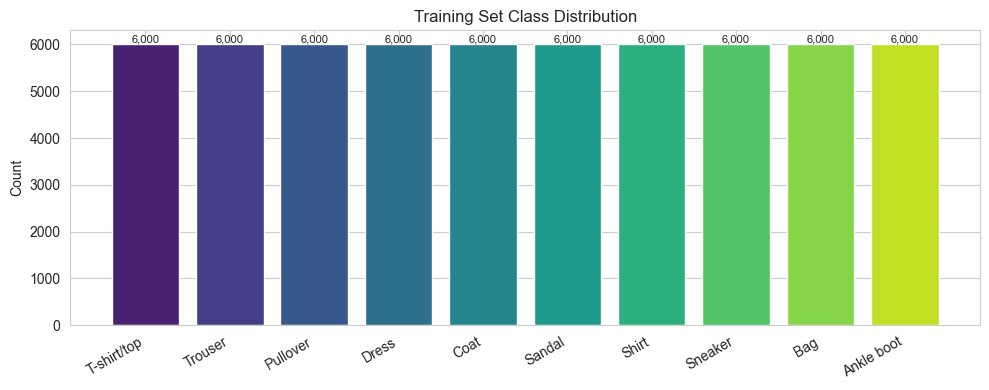


The dataset is perfectly balanced and there 6,000 samples per class.
We can use accuracy as an evaluation metric because there is no class imbalance.


In [5]:
# Class distribution
train_labels = [label for _, label in train_dataset]
label_counts = Counter(train_labels)

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(CLASS_NAMES, [label_counts[i] for i in range(10)], color=sns.color_palette('viridis', 10))
ax.set_ylabel('Count')
ax.set_title('Training Set Class Distribution')
ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right')
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{int(bar.get_height()):,}', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("\nThe dataset is perfectly balanced and there 6,000 samples per class.")
print("We can use accuracy as an evaluation metric because there is no class imbalance.")

### 1.2 Pixel Intensity Analysis

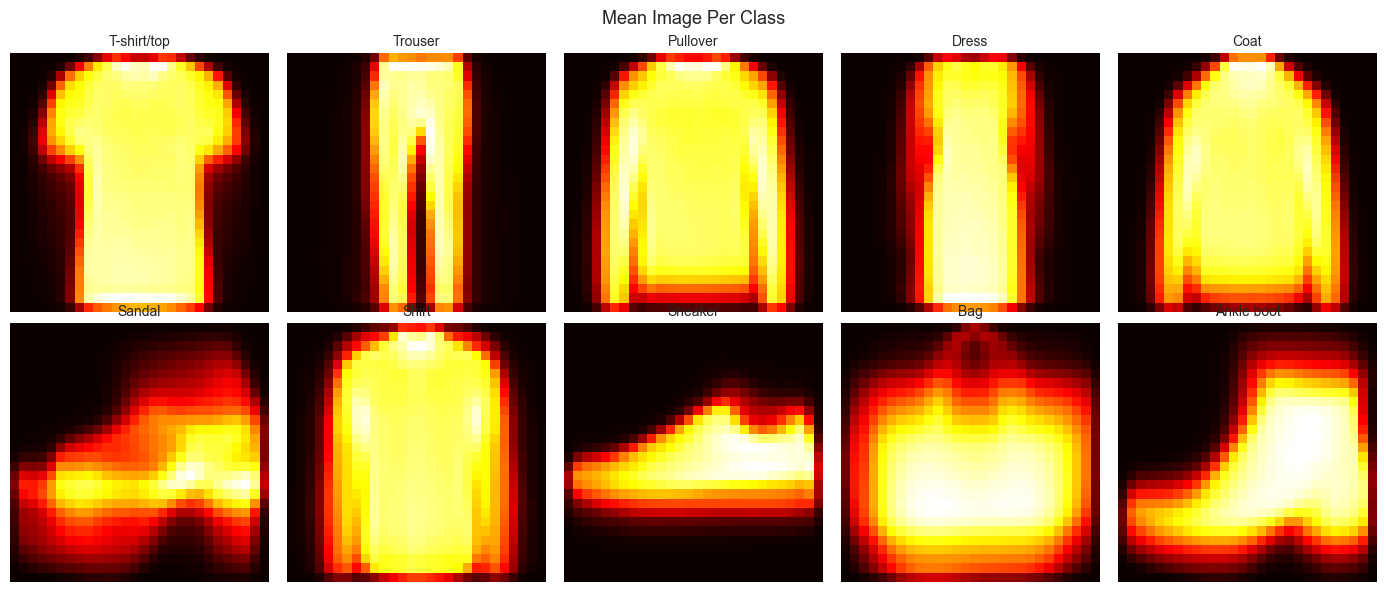

T-shirt, Pullover, Coat, and Shirt have very similar mean images.
Thus the network must learn very subtle features to be able to distinguish them.


In [7]:
# Compute mean image per class (using raw pixels, not normalized)
raw_transform = transforms.ToTensor()
raw_dataset = datasets.FashionMNIST(root='../data', train=True, download=False, transform=raw_transform)

mean_images = {}
for class_idx in range(10):
    class_imgs = torch.stack([raw_dataset[i][0] for i in range(len(raw_dataset)) if raw_dataset[i][1] == class_idx])
    mean_images[class_idx] = class_imgs.mean(dim=0).squeeze()

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
fig.suptitle('Mean Image Per Class', fontsize=13)

for idx, ax in enumerate(axes.flat):
    ax.imshow(mean_images[idx], cmap='hot')
    ax.set_title(CLASS_NAMES[idx], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../outputs/mean_images.png', dpi=150, bbox_inches='tight')
plt.show()

print("T-shirt, Pullover, Coat, and Shirt have very similar mean images.")
print("Thus the network must learn very subtle features to be able to distinguish them.")

---
## 2. Baseline Model

Starting with a simple 2-layer MLP as a baseline model

In [8]:
class BaselineMLP(nn.Module):
    """Simple 2-layer MLP. Mirrors what we built in Lab 2."""
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        return self.net(self.flatten(x))

# Train baseline
EPOCHS = 30
baseline_model = BaselineMLP().to(device)
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

total_params, _ = count_parameters(baseline_model)
print(f"Baseline MLP: {total_params:,} parameters")
print(f"Training for {EPOCHS} epochs...\n")

baseline_history = train_model(
    baseline_model, train_loader, test_loader, optimizer, criterion,
    device, epochs=EPOCHS
)

Baseline MLP: 109,386 parameters
Training for 30 epochs...

  Epoch   1/30 | Train Loss: 0.5076  Acc: 81.9% | Val Loss: 0.4366  Acc: 84.2%
  Epoch   5/30 | Train Loss: 0.2843  Acc: 89.3% | Val Loss: 0.3443  Acc: 87.4%
  Epoch  10/30 | Train Loss: 0.2219  Acc: 91.7% | Val Loss: 0.3368  Acc: 88.5%
  Epoch  15/30 | Train Loss: 0.1816  Acc: 93.1% | Val Loss: 0.3502  Acc: 88.6%
  Epoch  20/30 | Train Loss: 0.1501  Acc: 94.3% | Val Loss: 0.3680  Acc: 88.8%
  Epoch  25/30 | Train Loss: 0.1244  Acc: 95.3% | Val Loss: 0.4362  Acc: 88.7%
  Epoch  30/30 | Train Loss: 0.1098  Acc: 95.9% | Val Loss: 0.4632  Acc: 88.6%
  ✓ Best val acc: 88.99% at epoch 12 (215.6s)


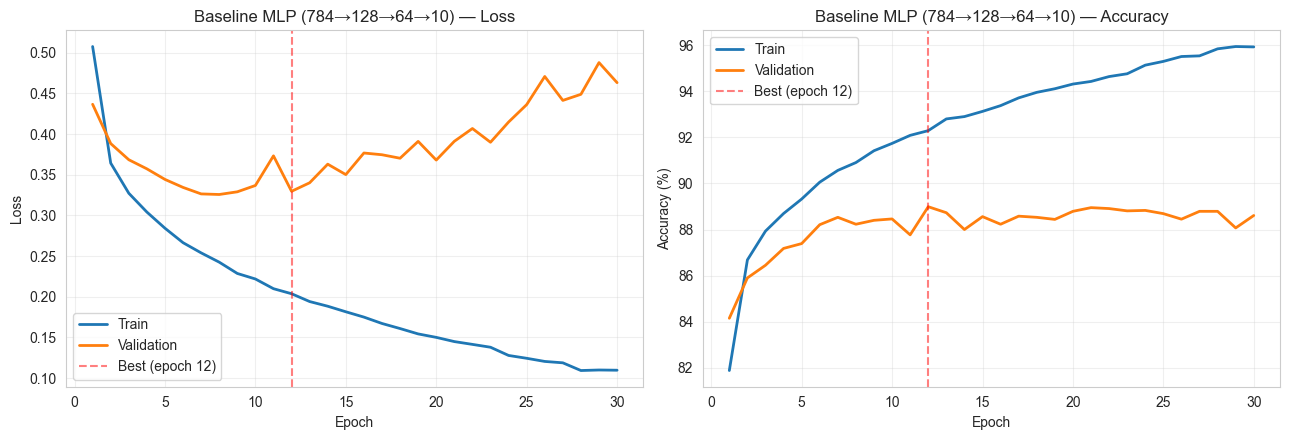

In [9]:
plot_training_curves(baseline_history, title='Baseline MLP (784→128→64→10)')

The baseline gives us a starting point. Notice how quickly the gap between train and validation accuracy appears — the model starts overfitting early, which motivates our regularization experiments later.

---
## 3. Architecture Experiments

Now we systematically vary one architectural dimension at a time. This is critical for understanding *what* each design choice contributes — changing multiple things at once makes it impossible to attribute improvements.

### 3.1 Experiment: Network Depth

**Question**: Does adding more layers help? When does it start to hurt?

Theory: Deeper networks can learn more abstract hierarchical features, but they're also harder to train due to vanishing/exploding gradients. With plain MLPs (no skip connections), we should see diminishing returns or degradation beyond a certain depth.

In [ ]:
class FlexibleMLP(nn.Module):
    """
    MLP with configurable depth, width, and activation.
    All hidden layers use the same width for controlled experiments.
    """
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10,
                 num_hidden=2, activation='relu', dropout=0.0, use_batchnorm=False):
        super().__init__()
        self.flatten = nn.Flatten()
        
        # Map activation names to functions
        act_fn = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
            'sigmoid': nn.Sigmoid()
        }[activation]
        
        layers = []
        # First hidden layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(act_fn)
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        
        # Additional hidden layers
        for _ in range(num_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(act_fn)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        
        # Output
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(self.flatten(x))

In [ ]:
# Depth experiment: 1, 2, 3, 5, 8 hidden layers (all width=128)
depth_results = {}
depth_configs = [1, 2, 3, 5, 8]

for n_layers in depth_configs:
    name = f"{n_layers} hidden layer{'s' if n_layers > 1 else ''}"
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    
    model = FlexibleMLP(num_hidden=n_layers, hidden_dim=128).to(device)
    total, _ = count_parameters(model)
    print(f"  Parameters: {total:,}")
    
    opt = optim.Adam(model.parameters(), lr=1e-3)
    history = train_model(model, train_loader, test_loader, opt, criterion, device, epochs=EPOCHS)
    depth_results[name] = history

In [ ]:
compare_experiments(depth_results)
plt.savefig('../outputs/depth_comparison.png', dpi=150, bbox_inches='tight')

In [ ]:
# Overlay all depth loss curves for direct comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = sns.color_palette('viridis', len(depth_results))

for (name, hist), color in zip(depth_results.items(), colors):
    epochs = range(1, len(hist['val_loss']) + 1)
    ax1.plot(epochs, hist['val_loss'], label=name, color=color, linewidth=2)
    ax2.plot(epochs, hist['val_acc'], label=name, color=color, linewidth=2)

ax1.set_xlabel('Epoch'); ax1.set_ylabel('Validation Loss')
ax1.set_title('Depth Experiment — Validation Loss'); ax1.legend(fontsize=8)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Depth Experiment — Validation Accuracy'); ax2.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../outputs/depth_curves.png', dpi=150, bbox_inches='tight')
plt.show()

**Analysis — Depth:**

Examine the results above and note:
- How does validation accuracy change as we add layers?
- At what depth do we start seeing diminishing returns or degradation?
- Look at the loss curves: do deeper models overfit more or less?
- The 8-layer model likely trains slower and may perform worse — this is the **degradation problem** that motivated residual networks (He et al., 2015).

*Your observations:* [Add your analysis after running]

### 3.2 Experiment: Network Width

**Question**: Is it better to go wider or deeper? How much capacity does this task actually need?

We fix depth at 2 hidden layers and vary width. This tests the model's *capacity* — its ability to represent complex decision boundaries.

In [ ]:
width_results = {}
width_configs = [32, 64, 128, 256, 512]

for width in width_configs:
    name = f"Width {width}"
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    
    model = FlexibleMLP(num_hidden=2, hidden_dim=width).to(device)
    total, _ = count_parameters(model)
    print(f"  Parameters: {total:,}")
    
    opt = optim.Adam(model.parameters(), lr=1e-3)
    history = train_model(model, train_loader, test_loader, opt, criterion, device, epochs=EPOCHS)
    width_results[name] = history

In [ ]:
compare_experiments(width_results)
plt.savefig('../outputs/width_comparison.png', dpi=150, bbox_inches='tight')

**Analysis — Width:**

- Width 32 is likely underfitting (not enough capacity). Width 512 probably overfits faster.
- There's a sweet spot: enough capacity to model the task, but not so much that the model memorizes the training set.
- Compare parameter counts: Width 512 has ~16x more parameters than Width 32. Is the accuracy gain proportional?
- This illustrates the **bias-variance tradeoff** in a concrete, measurable way.

*Your observations:* [Add your analysis after running]

### 3.3 Experiment: Activation Functions

**Question**: How much does the choice of activation function matter?

We test five activations with identical architectures (2 layers, width 128). Each activation has different properties: ReLU can cause dead neurons, sigmoid saturates, GELU is the modern default in transformers.

In [ ]:
activation_results = {}
activations = ['relu', 'tanh', 'leaky_relu', 'gelu', 'sigmoid']

for act in activations:
    name = act.upper() if act != 'leaky_relu' else 'LeakyReLU'
    if act == 'gelu': name = 'GELU'
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    
    model = FlexibleMLP(num_hidden=2, hidden_dim=128, activation=act).to(device)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    history = train_model(model, train_loader, test_loader, opt, criterion, device, epochs=EPOCHS)
    activation_results[name] = history

In [ ]:
compare_experiments(activation_results)
plt.savefig('../outputs/activation_comparison.png', dpi=150, bbox_inches='tight')

**Analysis — Activation Functions:**

- Sigmoid likely underperforms due to the **vanishing gradient** problem: its gradients are tiny for large/small inputs.
- ReLU, LeakyReLU, and GELU should perform similarly. The differences are more pronounced in deeper networks.
- Tanh centers outputs around zero (which can help), but also suffers from saturation.
- GELU is a smooth approximation of ReLU that allows small negative values — it's become the default in modern architectures (GPT, BERT) for good reason.

*Your observations:* [Add your analysis after running]

### 3.4 Experiment: Skip Connections

**Question**: Can residual connections help plain MLPs?

Skip (residual) connections let gradients flow directly through the network, addressing the degradation problem we likely observed in the depth experiment. Let's test whether adding residual connections to a deep MLP recovers the performance.

In [ ]:
class ResidualBlock(nn.Module):
    """A single residual block: Linear → BN → ReLU → Linear → BN + skip."""
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.block(x) + x)  # The skip connection


class ResidualMLP(nn.Module):
    """MLP with residual connections. Comparable depth to the deep plain MLPs."""
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10, num_blocks=3):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(*[ResidualBlock(hidden_dim) for _ in range(num_blocks)])
        self.head = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.input_proj(x)
        x = self.blocks(x)
        return self.head(x)

In [ ]:
skip_results = {}

# Deep plain MLP (8 layers) for comparison
print("Training: Deep Plain MLP (8 layers)")
plain_deep = FlexibleMLP(num_hidden=8, hidden_dim=128).to(device)
opt = optim.Adam(plain_deep.parameters(), lr=1e-3)
skip_results['Plain 8-layer'] = train_model(
    plain_deep, train_loader, test_loader, opt, criterion, device, epochs=EPOCHS
)

# Residual MLP (3 blocks = 6 layers effective depth + input proj)
print("\nTraining: Residual MLP (3 blocks)")
res_model = ResidualMLP(num_blocks=3).to(device)
total, _ = count_parameters(res_model)
print(f"  Parameters: {total:,}")
opt = optim.Adam(res_model.parameters(), lr=1e-3)
skip_results['Residual 3-block'] = train_model(
    res_model, train_loader, test_loader, opt, criterion, device, epochs=EPOCHS
)

# Residual MLP (5 blocks = deeper)
print("\nTraining: Residual MLP (5 blocks)")
res_model_5 = ResidualMLP(num_blocks=5).to(device)
opt = optim.Adam(res_model_5.parameters(), lr=1e-3)
skip_results['Residual 5-block'] = train_model(
    res_model_5, train_loader, test_loader, opt, criterion, device, epochs=EPOCHS
)

compare_experiments(skip_results)
plt.savefig('../outputs/skip_connection_comparison.png', dpi=150, bbox_inches='tight')

**Analysis — Skip Connections:**

- Compare the residual models to the plain 8-layer network. The residual versions should train more stably and achieve higher accuracy.
- The key insight: skip connections don't add capacity — they add **trainability**. The network can always learn the identity mapping (set residual weights to zero), so depth never *hurts*.
- This is the same principle behind ResNets, which enabled training of 100+ layer networks for image classification.

*Your observations:* [Add your analysis after running]

---
## 4. Optimization Deep-Dive

Architecture defines *what* the model can learn; optimization determines *how well* it actually learns it. We'll now fix a good architecture and experiment with the training recipe.

### 4.1 Experiment: Optimizer Comparison

**Question**: How do different optimizers affect convergence speed and final performance?

We compare four popular optimizers, each representing a different approach to navigating the loss landscape:
- **SGD**: Vanilla stochastic gradient descent — the simplest possible approach
- **SGD + Momentum**: Adds "inertia" to avoid oscillation in ravines
- **Adam**: Adaptive learning rates per-parameter + momentum
- **AdamW**: Adam with proper weight decay (decoupled from the gradient)

In [ ]:
opt_results = {}

optimizer_configs = {
    'SGD (lr=0.01)': lambda params: optim.SGD(params, lr=0.01),
    'SGD + Momentum': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    'Adam (lr=1e-3)': lambda params: optim.Adam(params, lr=1e-3),
    'AdamW (lr=1e-3)': lambda params: optim.AdamW(params, lr=1e-3, weight_decay=1e-2)
}

for name, make_opt in optimizer_configs.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    
    model = FlexibleMLP(num_hidden=2, hidden_dim=256).to(device)
    opt = make_opt(model.parameters())
    history = train_model(model, train_loader, test_loader, opt, criterion, device, epochs=EPOCHS)
    opt_results[name] = history

In [ ]:
# Overlay training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = sns.color_palette('Set2', len(opt_results))

for (name, hist), color in zip(opt_results.items(), colors):
    epochs = range(1, len(hist['train_loss']) + 1)
    ax1.plot(epochs, hist['train_loss'], label=name, color=color, linewidth=2)
    ax2.plot(epochs, hist['val_acc'], label=name, color=color, linewidth=2)

ax1.set_xlabel('Epoch'); ax1.set_ylabel('Training Loss')
ax1.set_title('Optimizer Comparison — Training Loss'); ax1.legend(fontsize=9)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Optimizer Comparison — Validation Accuracy'); ax2.legend(fontsize=9)
plt.tight_layout()
plt.savefig('../outputs/optimizer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

**Analysis — Optimizers:**

- SGD converges slowly but can find flatter minima (better generalization). 
- Adam converges fast due to adaptive learning rates but may overfit more.
- AdamW adds weight decay to Adam — this regularizes the model and often matches or beats Adam.
- Momentum helps SGD enormously by smoothing the gradient direction.

*Your observations:* [Add your analysis after running]

### 4.2 Experiment: Learning Rate Schedules

**Question**: Does decaying the learning rate during training help?

The intuition: start with a large learning rate to make fast progress, then reduce it to fine-tune and settle into a good minimum.

In [ ]:
schedule_results = {}

# Fixed LR
print("Training: Constant LR")
model = FlexibleMLP(num_hidden=2, hidden_dim=256).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
schedule_results['Constant LR'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=40
)

# StepLR (decay by 0.5 every 10 epochs)
print("\nTraining: StepLR (×0.5 every 10 epochs)")
model = FlexibleMLP(num_hidden=2, hidden_dim=256).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
sched = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
schedule_results['StepLR'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=40, scheduler=sched
)

# CosineAnnealingLR
print("\nTraining: Cosine Annealing")
model = FlexibleMLP(num_hidden=2, hidden_dim=256).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=40)
schedule_results['Cosine Annealing'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=40, scheduler=sched
)

compare_experiments(schedule_results)
plt.savefig('../outputs/schedule_comparison.png', dpi=150, bbox_inches='tight')

### 4.3 Experiment: Regularization

**Question**: The baseline overfits. Can regularization close the train-val gap?

We test three complementary strategies:
- **Dropout**: Randomly zeroes neurons during training, forcing redundancy
- **Weight Decay (L2)**: Penalizes large weights, encouraging simpler solutions
- **Batch Normalization**: Normalizes intermediate activations, stabilizing training

In [ ]:
reg_results = {}

# No regularization
print("Training: No regularization")
model = FlexibleMLP(num_hidden=3, hidden_dim=256).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
reg_results['No regularization'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=40
)

# Dropout only
print("\nTraining: Dropout 0.3")
model = FlexibleMLP(num_hidden=3, hidden_dim=256, dropout=0.3).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
reg_results['Dropout 0.3'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=40
)

# Weight decay only
print("\nTraining: Weight Decay 1e-2")
model = FlexibleMLP(num_hidden=3, hidden_dim=256).to(device)
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
reg_results['Weight Decay'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=40
)

# BatchNorm only
print("\nTraining: BatchNorm")
model = FlexibleMLP(num_hidden=3, hidden_dim=256, use_batchnorm=True).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
reg_results['BatchNorm'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=40
)

# All combined
print("\nTraining: Dropout + Weight Decay + BatchNorm")
model = FlexibleMLP(num_hidden=3, hidden_dim=256, dropout=0.3, use_batchnorm=True).to(device)
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
reg_results['All Combined'] = train_model(
    model, train_loader, test_loader, opt, criterion, device, epochs=40
)

In [ ]:
compare_experiments(reg_results)
plt.savefig('../outputs/regularization_comparison.png', dpi=150, bbox_inches='tight')

In [ ]:
# Show overfitting gap for each regularization method
fig, ax = plt.subplots(figsize=(12, 5))
colors = sns.color_palette('Set2', len(reg_results))

for (name, hist), color in zip(reg_results.items(), colors):
    gap = [t - v for t, v in zip(hist['train_acc'], hist['val_acc'])]
    ax.plot(range(1, len(gap)+1), gap, label=name, color=color, linewidth=2)

ax.set_xlabel('Epoch')
ax.set_ylabel('Train Acc - Val Acc (% gap)')
ax.set_title('Generalization Gap: How Much is Each Model Overfitting?')
ax.legend(fontsize=9)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/generalization_gap.png', dpi=150, bbox_inches='tight')
plt.show()

**Analysis — Regularization:**

- The generalization gap plot is key: it shows how much each method reduces the train-val accuracy difference.
- Dropout forces the network to learn redundant representations — no single neuron can be a "crutch."
- BatchNorm smooths the optimization landscape, which often implicitly regularizes.
- Combining all methods should give the smallest gap without sacrificing too much training speed.

*Your observations:* [Add your analysis after running]

---
## 5. Visualization & Interpretability

Numbers and curves tell us *how well* the model does. Now let's understand *what* it's actually learning.

### 5.1 Best Model — Confusion Matrix

Train the best configuration we've found so far, then examine where it fails.

In [ ]:
# Train our best model: Residual MLP with full regularization
print("Training best model: Residual MLP + Dropout + BatchNorm + AdamW + Cosine LR")
best_model = ResidualMLP(num_blocks=3, hidden_dim=256).to(device)

# Add dropout to residual model manually
class BestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input_proj = nn.Sequential(
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.blocks = nn.Sequential(
            ResidualBlock(256),
            nn.Dropout(0.2),
            ResidualBlock(256),
            nn.Dropout(0.2),
            ResidualBlock(256),
            nn.Dropout(0.2)
        )
        self.head = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.input_proj(x)
        x = self.blocks(x)
        return self.head(x)

best_model = BestModel().to(device)
total, _ = count_parameters(best_model)
print(f"Parameters: {total:,}")

opt = optim.AdamW(best_model.parameters(), lr=1e-3, weight_decay=1e-2)
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=50)
best_history = train_model(
    best_model, train_loader, test_loader, opt, criterion, device, epochs=50, scheduler=sched
)

# Restore best weights
best_model.load_state_dict(best_history['best_model'])

In [ ]:
plot_training_curves(best_history, title='Best Model')

In [ ]:
cm = plot_confusion_matrix(best_model, test_loader, device, CLASS_NAMES, title='Best Model — Confusion Matrix')
plt.savefig('../outputs/confusion_matrix.png', dpi=150, bbox_inches='tight')

In [ ]:
# Per-class accuracy breakdown
from utils import evaluate
_, _, preds, labels = evaluate(best_model, test_loader, criterion, device)

print("Per-Class Accuracy:")
print("=" * 40)
class_acc = []
for i, name in enumerate(CLASS_NAMES):
    mask = labels == i
    acc = (preds[mask] == labels[mask]).mean() * 100
    class_acc.append(acc)
    print(f"  {name:15s}: {acc:.1f}%")

print(f"\n  {'Overall':15s}: {(preds == labels).mean() * 100:.1f}%")
print(f"\n  Hardest class:  {CLASS_NAMES[np.argmin(class_acc)]} ({min(class_acc):.1f}%)")
print(f"  Easiest class:  {CLASS_NAMES[np.argmax(class_acc)]} ({max(class_acc):.1f}%)")

### 5.2 Misclassification Analysis

Let's look at specific examples the model gets wrong. This gives qualitative insight into the model's failure modes.

In [ ]:
# Find misclassified examples
best_model.eval()
misclassified = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        img, label = test_dataset[i]
        output = best_model(img.unsqueeze(0).to(device))
        pred = output.argmax(1).item()
        conf = torch.softmax(output, dim=1).max().item()
        if pred != label:
            misclassified.append((img, label, pred, conf))

print(f"Total misclassified: {len(misclassified)} / {len(test_dataset)} ({100*len(misclassified)/len(test_dataset):.1f}%)")

# Show 15 random misclassifications
fig, axes = plt.subplots(3, 5, figsize=(14, 8))
fig.suptitle('Misclassified Examples: True → Predicted (Confidence)', fontsize=13)

sample = np.random.choice(len(misclassified), min(15, len(misclassified)), replace=False)
for ax, idx in zip(axes.flat, sample):
    img, true, pred, conf = misclassified[idx]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"{CLASS_NAMES[true]}\n→ {CLASS_NAMES[pred]} ({conf:.0%})", fontsize=8,
                 color='red' if conf > 0.8 else 'orange')
    ax.axis('off')

plt.tight_layout()
plt.savefig('../outputs/misclassified_examples.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.3 Learned Representations (t-SNE)

We extract the activations from the penultimate layer and project them to 2D using t-SNE. If the model has learned good features, we should see clear clusters per class.

In [ ]:
# Compare representations: baseline vs best model
print("Extracting features from baseline model...")
baseline_model.load_state_dict(baseline_history['best_model'])
baseline_feats, baseline_labels = extract_features(baseline_model, test_loader, device)
plot_tsne(baseline_feats, baseline_labels, CLASS_NAMES, title='t-SNE: Baseline MLP Representations')
plt.savefig('../outputs/tsne_baseline.png', dpi=150, bbox_inches='tight')

In [ ]:
print("Extracting features from best model...")
best_feats, best_labels = extract_features(best_model, test_loader, device)
plot_tsne(best_feats, best_labels, CLASS_NAMES, title='t-SNE: Best Model Representations')
plt.savefig('../outputs/tsne_best.png', dpi=150, bbox_inches='tight')

**Analysis — Representations:**

Compare the two t-SNE plots:
- The best model should show tighter, more separated clusters.
- Notice which classes overlap — these are the same pairs that confuse the classifier in the confusion matrix.
- Footwear (Sandal, Sneaker, Ankle boot) and upper-body clothing (T-shirt, Pullover, Coat, Shirt) likely form two super-clusters.

*Your observations:* [Add your analysis after running]

### 5.4 Weight Distribution Analysis

Visualizing the distribution of weights across layers can reveal training health issues like vanishing gradients or poorly initialized layers.

In [ ]:
# Plot weight distributions for each layer
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Weight Distributions Across Layers (Best Model)', fontsize=13)

linear_layers = [(name, param) for name, param in best_model.named_parameters() 
                 if 'weight' in name and param.dim() == 2]

# Sample up to 4 layers
sample_layers = linear_layers[::max(1, len(linear_layers)//4)][:4]

for ax, (name, param) in zip(axes, sample_layers):
    weights = param.detach().cpu().numpy().flatten()
    ax.hist(weights, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
    ax.set_title(f"{name}\nμ={weights.mean():.4f}, σ={weights.std():.4f}", fontsize=9)
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../outputs/weight_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Summary of All Experiments

Let's compile a comprehensive comparison table.

In [ ]:
# Summary table
all_experiments = {
    **{f'Depth: {k}': v for k, v in depth_results.items()},
    **{f'Width: {k}': v for k, v in width_results.items()},
    **{f'Act: {k}': v for k, v in activation_results.items()},
    **{f'Skip: {k}': v for k, v in skip_results.items()},
    **{f'Opt: {k}': v for k, v in opt_results.items()},
    **{f'Reg: {k}': v for k, v in reg_results.items()},
    'Best Model': best_history
}

print(f"{'Experiment':<40s} {'Best Val Acc':>12s} {'Best Epoch':>12s} {'Time (s)':>10s}")
print('=' * 76)
for name, hist in sorted(all_experiments.items(), key=lambda x: -x[1]['best_val_acc']):
    print(f"{name:<40s} {hist['best_val_acc']:>11.2f}% {hist['best_epoch']:>10d} {hist['elapsed_time']:>10.1f}")

---
## 7. Conclusions & Reflections

### Key Takeaways

**Architecture:**
- [Fill in after running: What depth worked best? Where did plain MLPs degrade?]
- [How much did width matter vs. depth?]
- [Did skip connections rescue deep models?]

**Optimization:**
- [Which optimizer performed best? Was it the fastest too?]
- [Did learning rate schedules help?]
- [Which regularization strategy was most effective?]

**Interpretability:**
- [Which class pairs were most confused? Why does this make intuitive sense?]
- [How did the t-SNE representations differ between baseline and best model?]

### Limitations

- We only explored MLPs — convolutional architectures (CNNs) would better exploit the spatial structure in images and likely outperform even our best MLP significantly.
- Fashion-MNIST, while harder than MNIST, is still a relatively simple benchmark. Real-world image classification involves color, variable sizes, backgrounds, and occlusion.
- We used a fixed train/test split rather than cross-validation, so our results have some variance.
- Hyperparameter search was manual; Bayesian optimization or grid search might find better configurations.

### Connection to Course Material

This exploration directly connects to several concepts from the course:
- **Gradient flow** (Lecture X): We saw empirically that deeper plain networks train worse, and skip connections solve this.
- **Regularization** (Lecture X): Dropout, weight decay, and BatchNorm each address overfitting from a different angle.
- **Representation learning** (Lecture X): The t-SNE visualizations show how networks transform raw pixels into linearly separable features.
- **Bias-variance tradeoff**: Width and depth experiments directly demonstrate the tension between model capacity and generalization.

### What I Would Do Next

1. Implement a simple CNN and compare it to the MLP — the spatial structure in images should give a significant boost.
2. Try data augmentation (random flips, rotations) to see how it affects generalization.
3. Implement gradient-based interpretability (saliency maps) to see which pixels drive predictions.